In [1]:
import pandas as pd
import numpy as np
import random

In [51]:
SIGMA_SL = -1
SIGMA_TP = 1.5
MAX_TRADE_DURATION = 63
PTF_VOL_TGT = 0.15
AUM = 100000
AUM_LOST_SL = 0.005

In [52]:
df = pd.read_csv('dataset_tmc.csv', parse_dates = ['Dates'], date_format = '%d/%m/%y')
df.columns = [i.lower() for i in df.columns]
df.columns = [i.replace(' ','_') for i in df.columns]
df = df.set_index('dates')

# Check NaNs
if df.isna().sum().sum() != 0:
    print('check NaNs in data')

# refill Sat&Sun
refilled = df.reindex(pd.date_range(df.index.min(), df.index.max()), method='ffill')

In [91]:
# hardcoded start allowing 5Y of data for Stdev calc and Max Duration of trades
# startdates = list(df.loc['2018-03-12':df.tail(MAX_TRADE_DURATION).index.astype(str)[0]].index.astype(str))

date_index_reference = df.loc['2018-03-12':'2019-03-12'].index
startdates = list(date_index_reference.astype(str))


trades_df = pd.DataFrame()
ctrvl = pd.DataFrame(index = date_index_reference)
ctrvl['AUM'] = AUM
ctrvl_pos = pd.DataFrame(index = date_index_reference)

for i in range(2):
    security_id = random.choice(list(df.columns))
    trade_entry_date = random.choice(startdates)
    direction = random.choice([-1, 1])

    # compute 5Y Monthly standard deviation starting from date of trade entry and going backward
    hist_stdev = refilled.loc[refilled.index.isin(pd.date_range(end=trade_entry_date, periods=60+1, freq=pd.DateOffset(months=1))), security_id
                    ].pct_change().dropna().std() #* np.sqrt(12)

    trade_pnl = df.loc[trade_entry_date:, [security_id]].head(MAX_TRADE_DURATION+1)
    trade_pnl['security_id'] = security_id
    trade_pnl['direction'] = direction
    trade_pnl['hist_volatility'] = hist_stdev
    trade_pnl['entry_price'] = df.loc[trade_entry_date, security_id]
    trade_pnl['tp_price'] = trade_pnl['entry_price'] * (1 + hist_stdev * SIGMA_TP * direction)
    trade_pnl['sl_price'] = trade_pnl['entry_price'] * (1 + hist_stdev * SIGMA_SL * direction)
    trade_pnl['quantity'] = (AUM * AUM_LOST_SL) / ((trade_pnl['entry_price'] - trade_pnl['sl_price']) * direction)

    # check if TP/SL have been hitted 
    if direction == 1:
        trade_pnl['tp_hit'] = (trade_pnl[security_id] > trade_pnl['tp_price']) * 1
        trade_pnl['sl_hit'] = (trade_pnl[security_id] < trade_pnl['sl_price']) * 1
    elif direction == -1:
        trade_pnl['tp_hit'] = (trade_pnl[security_id] < trade_pnl['tp_price']) * 1
        trade_pnl['sl_hit'] = (trade_pnl[security_id] > trade_pnl['sl_price']) * 1

    trade_pnl['tp_sl_hit'] = trade_pnl['tp_hit'] + trade_pnl['sl_hit']

    # make exit condition from the trade explicit
    if trade_pnl['tp_sl_hit'].sum()==0:
        trade_pnl['exit_condition'] = 'max_duration'
        trade_pnl['exit_price'] = trade_pnl[security_id].iloc[-1]
    else:
        trade_pnl = trade_pnl.loc[:trade_pnl[trade_pnl['tp_sl_hit'] == 1].index[0]].copy()
        trade_pnl['exit_condition'] = 'stop_loss' if trade_pnl['sl_hit'].sum()==1 else 'take_profit'
        trade_pnl['exit_price'] = trade_pnl['sl_price'] if trade_pnl['sl_hit'].sum()==1 else trade_pnl['tp_price']

    # first day must be subtracted as it is the day when the trade is open
    trade_pnl['duration'] = len(trade_pnl)-1

    # store the trade
    trades_df = pd.concat([trades_df, trade_pnl[['security_id', 'direction', 'hist_volatility', 'entry_price',
       'tp_price', 'sl_price', 'quantity', 'exit_condition', 'exit_price', 'duration']].drop_duplicates()]).sort_index()
    
    # store controvalore
    ctrvl_aum = pd.concat([ctrvl_aum, 
                    (trade_pnl['entry_price'] * trade_pnl['quantity']).rename(f'{security_id}#{trade_entry_date}')], axis=1)
    
    ctrvl_pos = pd.concat([ctrvl_pos, 
                    (trade_pnl[security_id] * trade_pnl['quantity']).rename(f'{security_id}#{trade_entry_date}')], axis=1)
    

In [93]:
ctrvl_aum = ctrvl_aum.ffill().fillna(0)
ctrvl_aum['AUM'] - ctrvl_aum.iloc[:, 1:].sum(axis=1)

<Axes: xlabel='dates'>

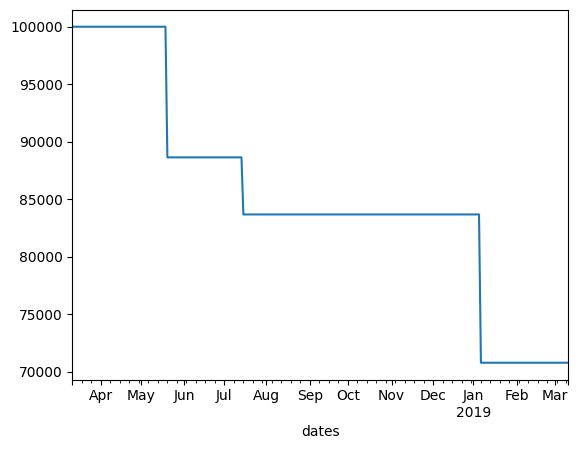

In [113]:
(ctrvl_aum['AUM'] - ctrvl_aum.iloc[:, 1:].sum(axis=1)).plot()